In [1]:
from scipy.linalg import svd
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import  clear_output
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Defining the helper functions and the models

**Note** : The model is constructed using only using Linear layers (one hidden layer and one output layer) for simplicity and to prove our point this is sufficient. And importantly the linear layers intialized with no bias present, to make our lives easier.

In [2]:
def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    model_size_mb = total_params * 4 / (1024 ** 2)  # Convert to MB (assuming float32)
    print(f"Model Size: {model_size_mb:.2f} MB")
    return model_size_mb

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Define a function to load the MNIST dataset
def load_mnist(batch_size):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, testloader

def test_model(model):
    # Testing loop
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct,total

# Define a simple feedforward neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512,bias=False)  # Input layer to hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 10,bias=False)  # Hidden layer to output layer

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    

class NetReconstructed(nn.Module):
    def __init__(self, decomposed_weight,custom_hidden_weights):
        super(NetReconstructed, self).__init__()
        self.U = nn.Linear(decomposed_weight[0].shape[1], decomposed_weight[0].shape[0],bias=False)  
        self.S = nn.Linear(decomposed_weight[1].shape[1], decomposed_weight[1].shape[0],bias=False)  
        self.Vh = nn.Linear(decomposed_weight[2].shape[1], decomposed_weight[2].shape[0],bias=False)  
        
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)  

        # Set custom weights for the hidden layer
        with torch.no_grad():
            self.U.weight.copy_(decomposed_weight[0])
            self.S.weight.copy_(decomposed_weight[1])
            self.Vh.weight.copy_(decomposed_weight[2])
            
            self.fc2.weight.copy_(custom_hidden_weights)
            

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.Vh(x)
        x = self.S(x)
        x = self.U(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

### Training & Testing the big model

In [3]:
# Initialize the neural network, loss function, and optimizer
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

# Load the MNIST dataset
batch_size = 64
trainloader, testloader = load_mnist(batch_size)

# Training loop
epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

print("Finished Training")

# Testing 
correct,total = test_model(net)
print(f"Accuracy on the test set: {100 * correct / total}%")

Epoch 1, Loss: 0.7071708253642389
Epoch 2, Loss: 0.3590520282131014
Epoch 3, Loss: 0.3148835263510884
Epoch 4, Loss: 0.287791384777217
Epoch 5, Loss: 0.2656276762437846
Epoch 6, Loss: 0.24576456542970784
Epoch 7, Loss: 0.22746289382452395
Epoch 8, Loss: 0.21143903574153686
Epoch 9, Loss: 0.19710641403172188
Epoch 10, Loss: 0.1840020162162623
Epoch 11, Loss: 0.17246652686440234
Epoch 12, Loss: 0.1620545075543082
Epoch 13, Loss: 0.15282674830383075
Epoch 14, Loss: 0.1444198288190276
Epoch 15, Loss: 0.1367216758044766
Epoch 16, Loss: 0.13033197440707417
Epoch 17, Loss: 0.12404325315311773
Epoch 18, Loss: 0.11827899765834879
Epoch 19, Loss: 0.11308168986244306
Epoch 20, Loss: 0.10828243062666643
Finished Training
Accuracy on the test set: 96.71%


We shall now look at the model size

In [4]:
get_model_size(net)

Model Size: 1.55 MB


1.55078125

Now lets extract the weight of the layer with the highest number of parameters, which is the hidden layer. The hidden layer has weight matrix of 784 x 512 learnable parameters. Which is a lot compared to the other layer which is only 512 x 10.

In [5]:
layer_name = 'fc1'  # Change this to the name of your specific layer
layer_weights = net.state_dict()[layer_name + '.weight']

We shall convert it the weight to numpy so we can perform svd using scipy

In [6]:
fc1_numpy = layer_weights.numpy()

In [7]:
u, s, vh = svd(fc1_numpy)

Lets plot the magnitude of the singular values

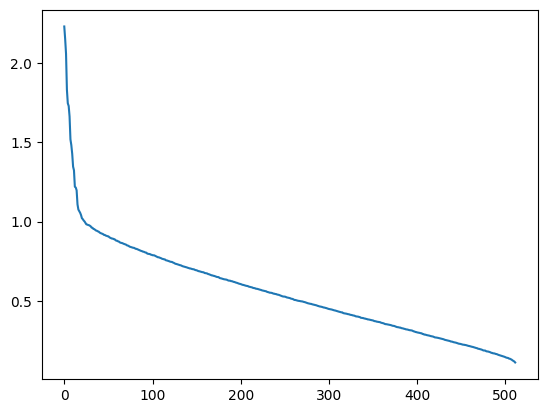

In [8]:
plt.plot(s)

We can also use *torch.linalg.svd* to obtain U, S and Vh

In [9]:
U, S, Vh = torch.linalg.svd(layer_weights)
U.shape, S.shape, Vh.shape

(torch.Size([512, 512]), torch.Size([512]), torch.Size([784, 784]))

Now lets perform low rank approximation on the layer weight, by choosing the rank to be equal to 25. We shall also see the distance between the original weight matrix and the rank 30 approximated matrix using the *torch.dist*

In [20]:
rank = 50
torch.dist(layer_weights, U[:, :rank] @ torch.diag(S[:rank]) @ Vh[:rank,:])

tensor(11.5067)

In [21]:
decomposed_weight = [U[:, :rank],torch.diag(S[:rank]),Vh[:rank,:]]
custom_hidden_weights = net.state_dict()["fc2.weight"]

In [22]:
reconstructed_net = NetReconstructed(decomposed_weight,custom_hidden_weights)

In [23]:
# Testing 
correct,total = test_model(reconstructed_net)

print(f"Accuracy on the test set: {100 * correct / total}%")

Accuracy on the test set: 96.06%


In [24]:
(get_model_size(reconstructed_net)/get_model_size(net))*100

Model Size: 0.28 MB
Model Size: 1.55 MB


17.816730950881613